# Example of high-level module using facility D, with fouling on the process side

This notebook demonstrates the use of the high-level module by performing decimal predictions using various machine learning models. A small selection of models and model architectures are chosen based on findings during the thesis work.

When using nothing but the high-level module, a specified recipe should be followed:
1. Define dataset specifics
2. Initiate and divide data
3. Define models
4. Initiate and train models
5. Make predictions

Because the high-level module stores state, the user is exposed to a limited number of return variables and the prediction process is streamlined. For more flexibility and a wider range of functionality, the underlying code library should be used instead of the high-level module.

## Step 0: Import modules

In [1]:
# %load 2_basic_example_D_h.py
import src.core as mlModule
model = 'A'

Using TensorFlow backend.


## Step 1: Define dataset specifics

In [2]:
# File path to dataset .csv file
filename = "../master-thesis-db/datasets/D/dataD.csv"

# List of columns on form ['name', 'description', 'unit']
columns = [
    ['20TT001', 'Process Inlet Temperature', 'Degrees'],
    ['20PT001', 'Process Inlet Pressure', 'Bar'],
    ['20FT001', 'Process Flow Rate', 'kg/hour'],
    ['20TT002', 'Process Outlet Temperature', 'Degrees'],
    ['20PDT001', 'Process Pressure Difference', 'Bar'],
    ['50TT001', 'Coolant Inlet Temperature', 'Degrees'],
    ['50PT001', 'Coolant Inlet Pressure', 'Bar'],
    ['50FT001', 'Coolant Flow Rate', 'kg/hour'],
    ['50TT002', 'Coolant Outlet Temperature', 'Degrees'],
    ['50PDT001', 'Coolant Pressure Difference', 'Bar'],
    ['50TV001', 'Coolant Valve Opening', '%'],
]

# List of column names to ignore completely
irrelevantColumns = [
    '20PT001',
    '50PT001',
    '50FT001',
    '50PDT001',
    '50TV001',
]

# List of column names used a targets
targetColumns = [
    '50TT002',
    '20PDT001',
]

# List of training periods on form ['start', 'end']
traintime = [
    ["2020-01-01 00:00:00", "2020-03-20 00:00:00"],
]

# Testing period, recommended: entire dataset
testtime = [
    "2020-01-01 00:00:00",
    "2020-08-01 00:00:00"
]

## Step 2: Initiate and divide data

The user should ensure the desired columns and descriptions are still in the dataset columns after removal. The number of samples matching the provided training and testing periods are displayed.

In [3]:
df = mlModule.initDataframe(filename, columns, irrelevantColumns)
df_train, df_test = mlModule.getTestTrainSplit(traintime, testtime)
X_train, y_train, X_test, y_test = mlModule.getFeatureTargetSplit(targetColumns)

Columns before removal: 
Col. 0 : 20TT001 - Process Inlet Temperature
Col. 1 : 20PT001 - Process Inlet Pressure
Col. 2 : 20FT001 - Process Flow Rate
Col. 3 : 20TT002 - Process Outlet Temperature
Col. 4 : 20PDT001 - Process Pressure Difference
Col. 5 : 50TT001 - Coolant Inlet Temperature
Col. 6 : 50PT001 - Coolant Inlet Pressure
Col. 7 : 50FT001 - Coolant Flow Rate
Col. 8 : 50TT002 - Coolant Outlet Temperature
Col. 9 : 50PDT001 - Coolant Pressure Difference
Col. 10 : 50TV001 - Coolant Valve Opening

Columns after removal: 
Col. 0 : 20TT001 - Process Inlet Temperature
Col. 1 : 20FT001 - Process Flow Rate
Col. 2 : 20TT002 - Process Outlet Temperature
Col. 3 : 20PDT001 - Process Pressure Difference
Col. 4 : 50TT001 - Coolant Inlet Temperature
Col. 5 : 50TT002 - Coolant Outlet Temperature

Finding data between 2020-01-01 00:00:00 and 2020-03-20 00:00:00
Found 315 rows

Finding data between 2020-01-01 00:00:00 and 2020-08-01 00:00:00
Found 726 rows



## Step 3: Define models

A selection of models are available from the src.core module. These include:
- Multilayer perceptron (MLP)
- Long short-term memory (LSTM)
- Gated Recurrent Unit (GRU)
- Linear models
- Tree-based models
- Ensemble models
- Autoencoder models

Parameters for each model and their effect are indicated in the documentation. A set of defaults are used for parameters not defined by the user. See the thesis for additional details.

In this example, MLP, LSTM and Ensemble models with specific architectures are used.

In [4]:
#mlp_1 = mlModule.MLP('MLP 1x64 d0.2 mod'+model, layers=[64], dropout=0.2)
mlp_2 = mlModule.MLP('MLP 1x128 d0.2 mod'+model, layers=[128], dropout=0.2)
#mlp_3 = mlModule.MLP('MLP 2x64 d0.2 mod'+model, layers=[64, 64], dropout=0.2)
#mlp_4 = mlModule.MLP('MLP 2x128 d0.2 mod'+model, layers=[128, 128], dropout=0.2)
#lstm_1 = mlModule.LSTM('LSTM 1x64 d0.2 mod'+model, layers=[64], dropout=0.2, recurrentDropout=0.2, enrolWindow=12)
lstm_2 = mlModule.LSTM('LSTM 1x128 d0.2 mod'+model, layers=[128], dropout=0.2, recurrentDropout=0.2, enrolWindow=12)
#lstm_3 = mlModule.LSTM('LSTM 2x64 d0.2 mod'+model, layers=[64, 64], dropout=0.2, recurrentDropout=0.2, enrolWindow=12)
#lstm_4 = mlModule.LSTM('LSTM 2x128 d0.2 mod'+model, layers=[128, 128], dropout=0.2, recurrentDropout=0.2, enrolWindow=12)
linear = mlModule.Linear_Regularized('Linear rCV mod'+model)
ensemble1 = mlModule.Ensemble('MLP 1x128 + Linear mod'+model, [mlp_2, linear])
ensemble2 = mlModule.Ensemble('LSTM 1x128 + Linear mod'+model, [lstm_2, linear])

modelList = [
    linear,
    #mlp_1,
    mlp_2,
    #mlp_3,
    #mlp_4,
    #lstm_1,
    lstm_2,
    #lstm_3,
    #lstm_4,
    ensemble1,
    ensemble2,
]

## Step 4. Initiate and train models

Models are retrained according to the *retrain* parameter. If *retrain* is false while no stored model is found, a new model is trained. Note that models for storage are defined by their **provided model name** and **the output variables** of the model. Input variables and model architecture are not considered when loading stored models. Hence, the mode name should unique describe the purpose of the model. For these models, some shortened names are used:
- 'MLP'/'LSTM'/'GRU'/'Linear' followed by two numbers separated by 'x', e.g. 'MLP 1x128', for model type and hidden layer architecture
- 'rCV' for ridge regularization and cross validation
- 'd0.X', e.g. 'd0.2', for dropout regularization, with rate 0.X
- 'X.XXX', e.g. '0.005' for ridge regularization, with rate 0.XXX 
- 'modX', e.g. 'modA' for predictive model X

From the model training, the following output can be seen:
- Indications whether a model was trained or loaded. If trainable methods are not loaded, output describing the learning iterations will be printed according to the previously provided verbose parameters or by default verbose parameters. For linear models, the trained weights will also be displayed
- Table of loss values for each trainable model. The training iteration with the minimum validation loss is chosen
- Plot of loss values for each trainable model. For model convergence, the validation loss should gradually decrease before a minimum point is reached, after which the validation loss should increase slightly before training is aborted

Training model Linear rCV modA
    Trained weights for Linear rCV modA:
[[-0.14606626 -0.98548659  0.04138034 -0.03906934]
 [ 0.00140211  0.99667678  0.00409289 -0.0084005 ]]
Model MLP 1x128 d0.2 modA was loaded from file
Model LSTM 1x128 d0.2 modA was loaded from file
Model MLP 1x128 + Linear modA was loaded from file
Training submodel Linear rCV modA of Ensemble MLP 1x128 + Linear modA
    Trained weights for Linear rCV modA:
[[-0.14606626 -0.98548659  0.04138034 -0.03906934]
 [ 0.00140211  0.99667678  0.00409289 -0.0084005 ]]
    Trained weights for Linear model of ensemble:
[[ 1.10756881  0.09647467 -0.11561373 -0.10325803]
 [ 0.02545751  1.02077432  0.00337196  0.00736348]]
Model LSTM 1x128 + Linear modA was loaded from file
Training submodel Linear rCV modA of Ensemble LSTM 1x128 + Linear modA
    Trained weights for Linear rCV modA:
[[-0.14606626 -0.98548659  0.04138034 -0.03906934]
 [ 0.00140211  0.99667678  0.00409289 -0.0084005 ]]
    Trained weights for Linear model of ensem

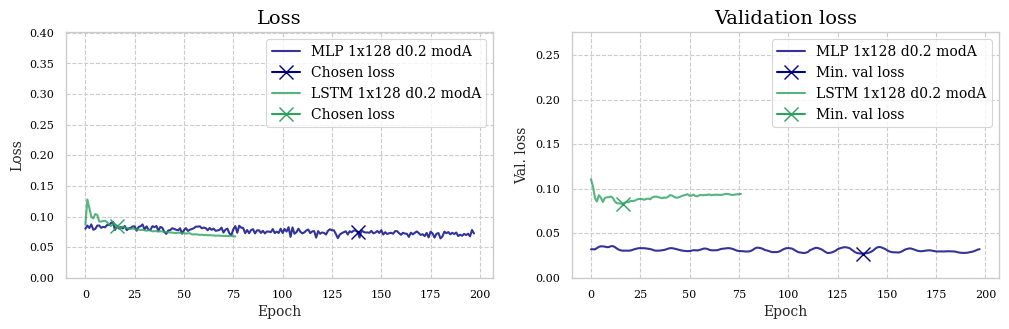

In [5]:
# Define whether to retrain models or not
retrain=False

mlModule.initModels(modelList)
mlModule.trainModels(retrain)

## Step 5: Make predictions

Predictions are made for all provided models at once using the *predictWithModels* method. If individual predictions are desired (e.g. for plot readability), the models can be passed individually through a loop.

From the prediction methods, the following output can be seen:
- Table of scores for each method on the training and testing data, using the provided or default loss metric. Note that the test score is not necessarily relevant if a training period of expected deviation is used
- Plot of target values and predicted values for each model, for each output variable
- Plot of deviation between target value and predicted value for each model, for each output variable
- Plot of calculated R2-score on the training set for each model

Model prediction scores
+--------------------------+-------------+------------+
|          Model           | Train score | Test score |
+--------------------------+-------------+------------+
|     Linear rCV modA      |    0.9938   |   0.915    |
|   MLP 1x128 d0.2 modA    |    0.9987   |   0.8701   |
|   LSTM 1x128 d0.2 modA   |    0.9791   |   0.2439   |
| MLP 1x128 + Linear modA  |    0.9987   |   0.8662   |
| LSTM 1x128 + Linear modA |    0.996    |   0.8721   |
+--------------------------+-------------+------------+


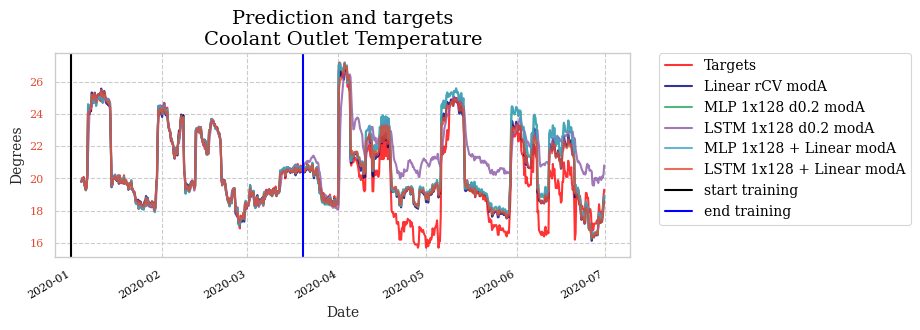

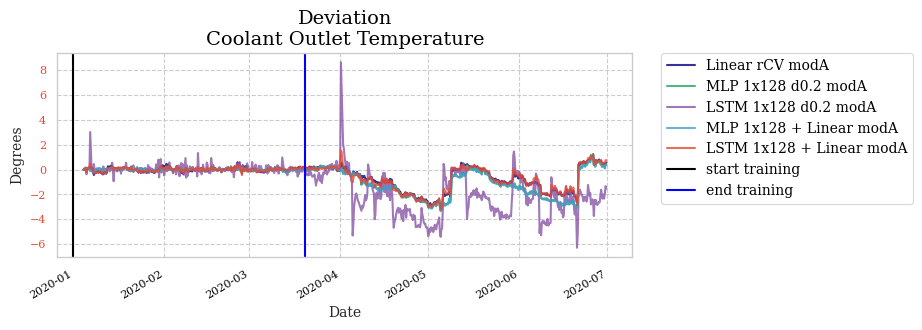

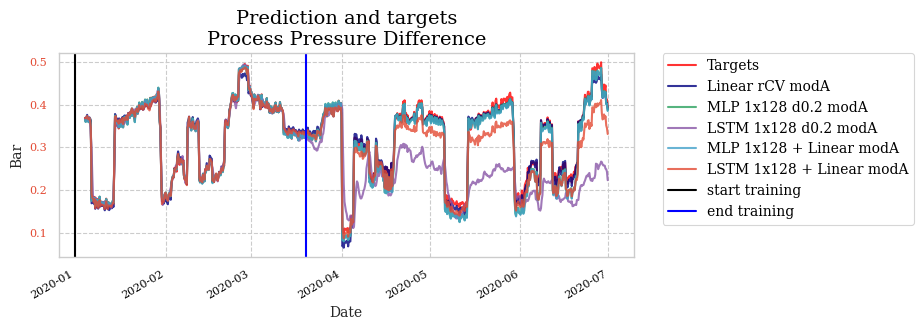

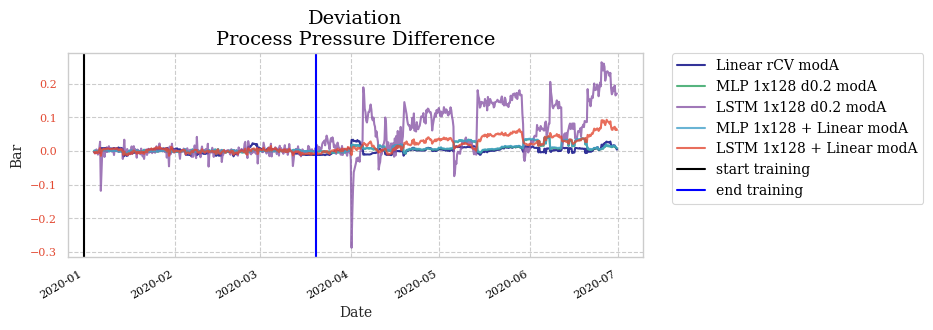

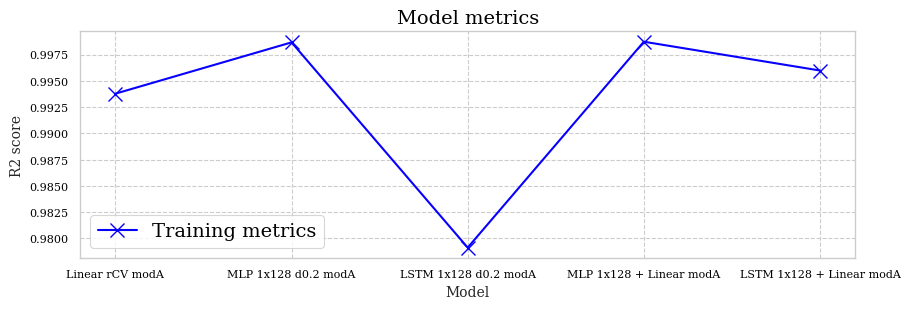

In [6]:
modelNames, metrics_train, metrics_test, columnsList, deviationsList = mlModule.predictWithModels(
	plot=True,
	interpol=False,
	score=True,
)

## Additional plots

The following individual plots are added for visualization purposes. Predictions and deviation for each model is printed separately. Note that this is not part of the 'recipe' defined for the high-level module.

For this dataset, the function describing the added level of fouling during simulations is also plotted.

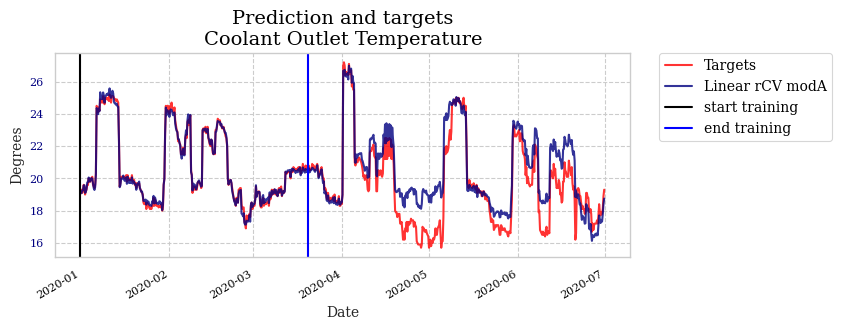

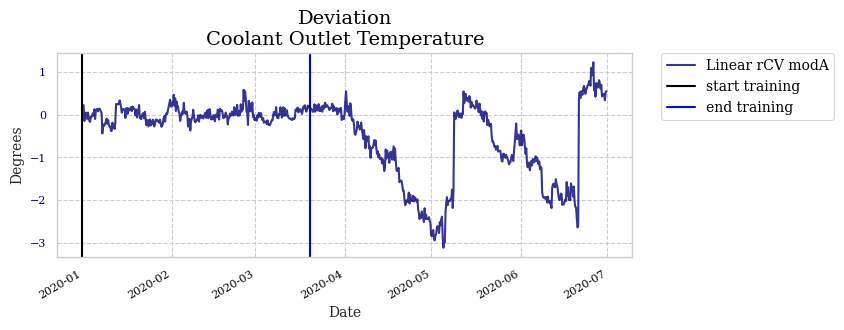

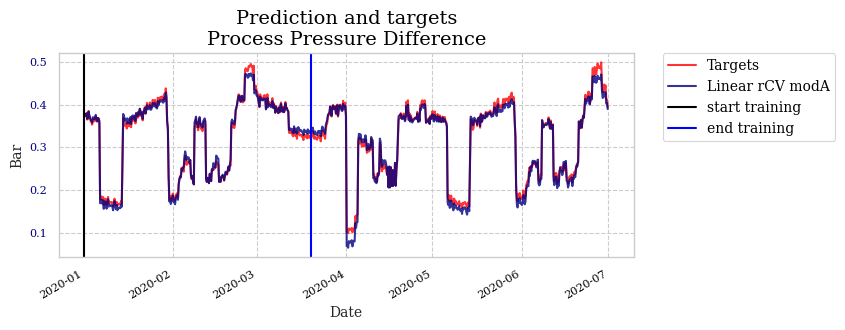

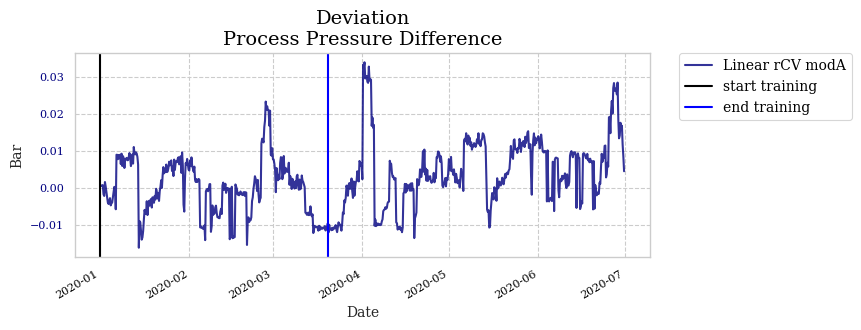

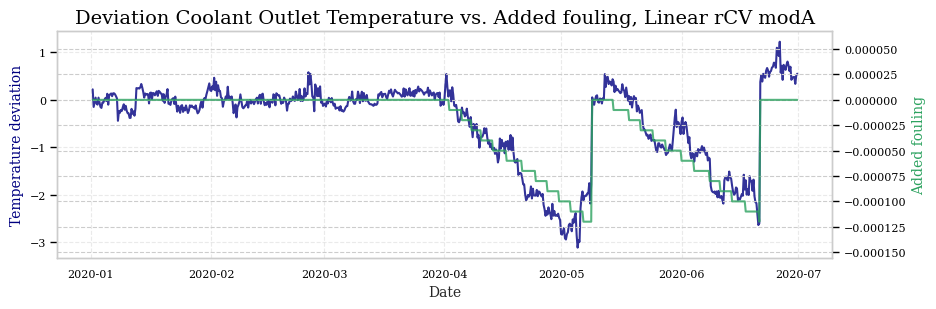

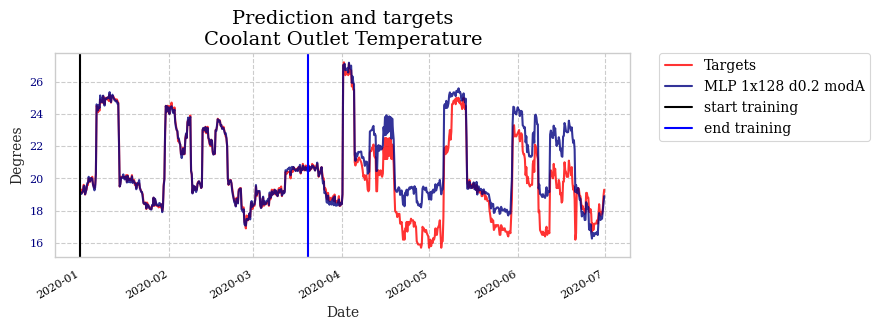

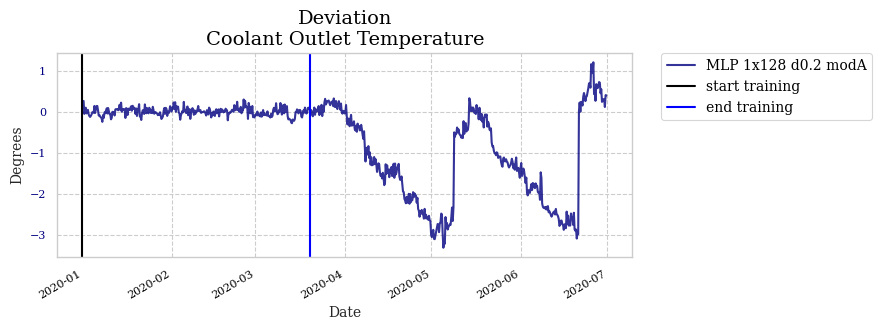

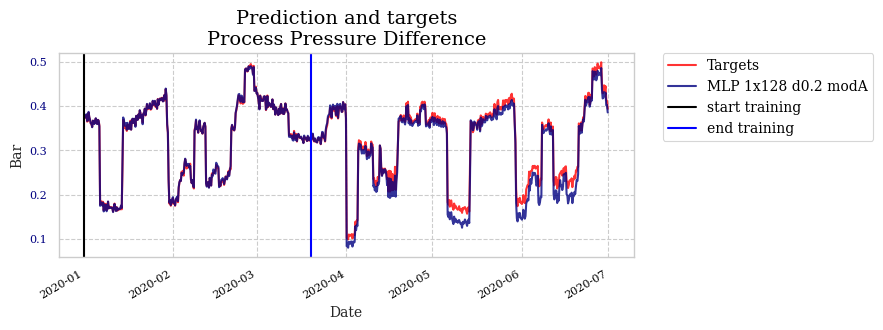

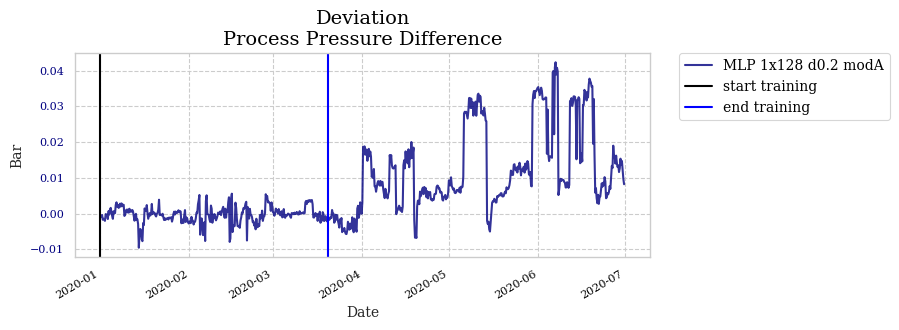

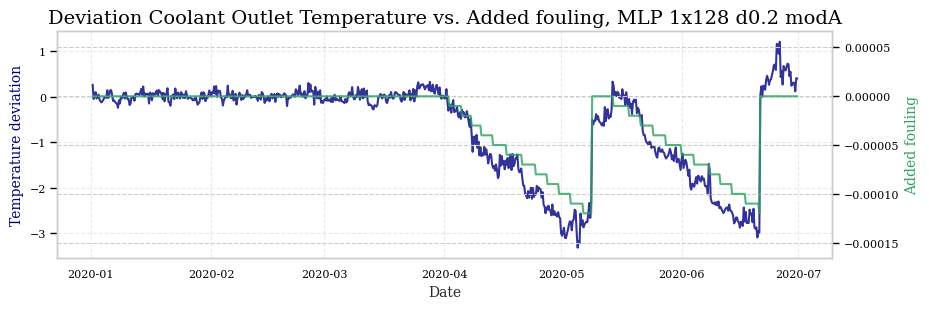

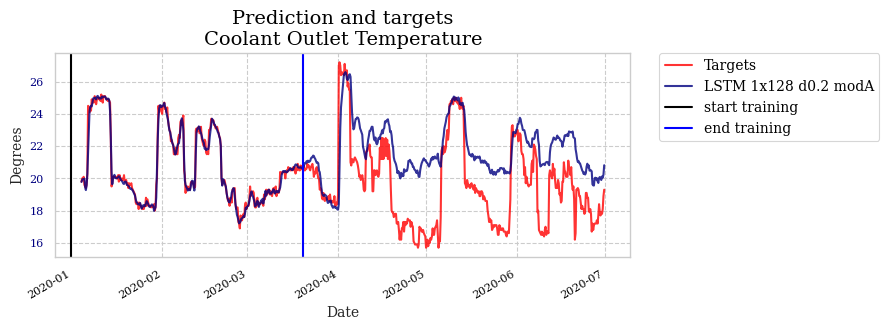

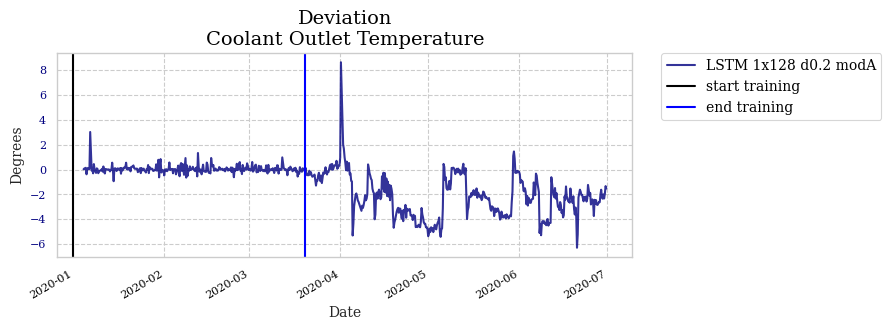

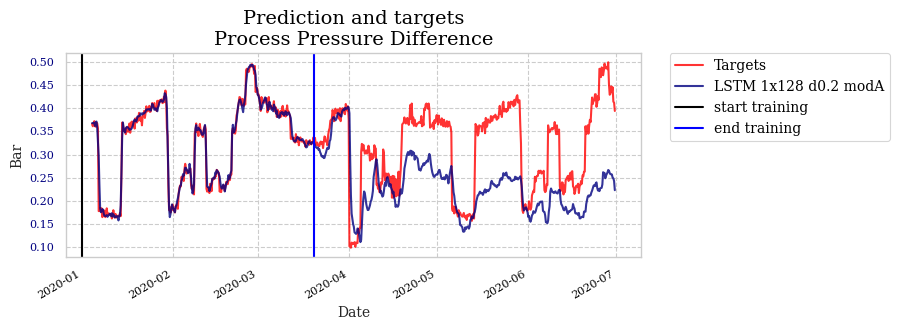

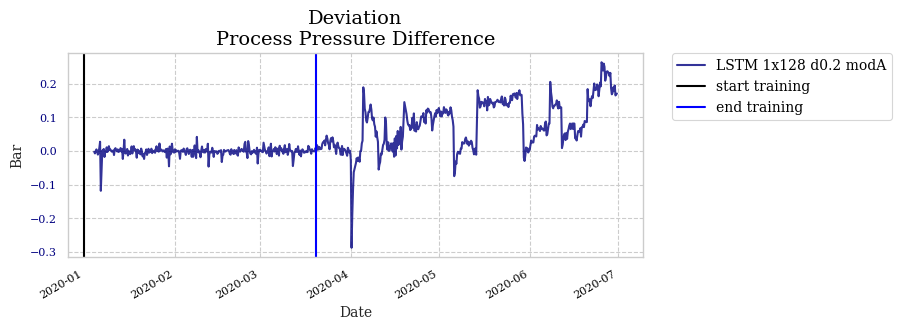

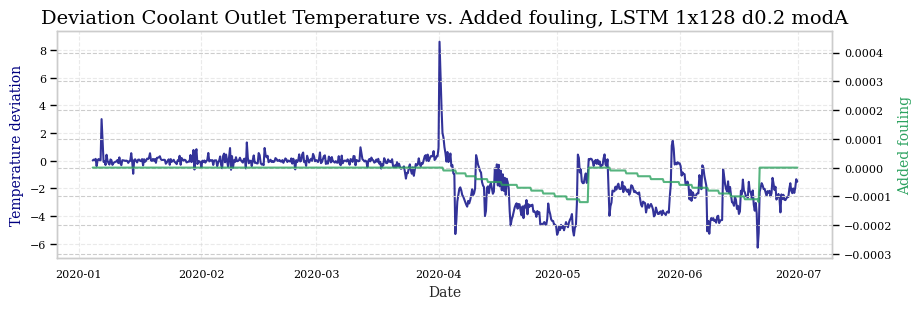

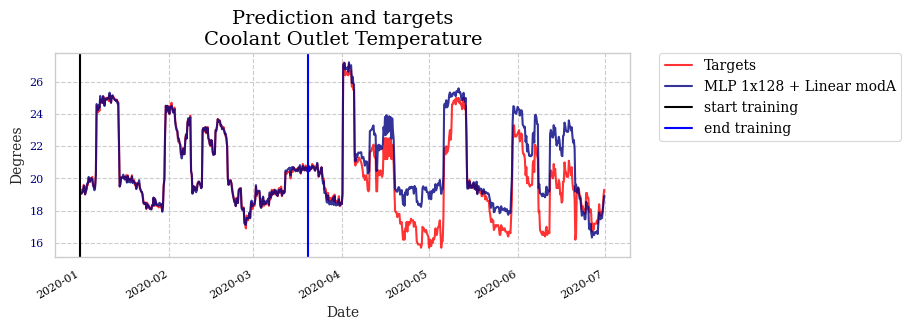

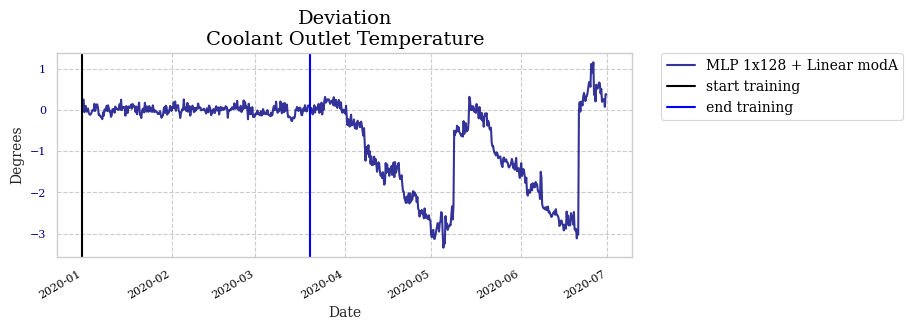

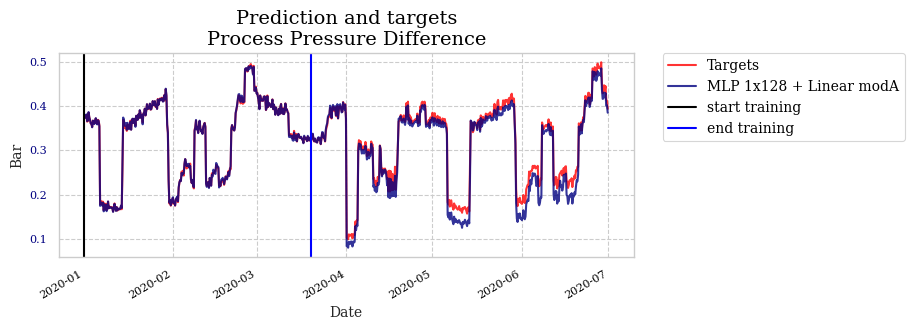

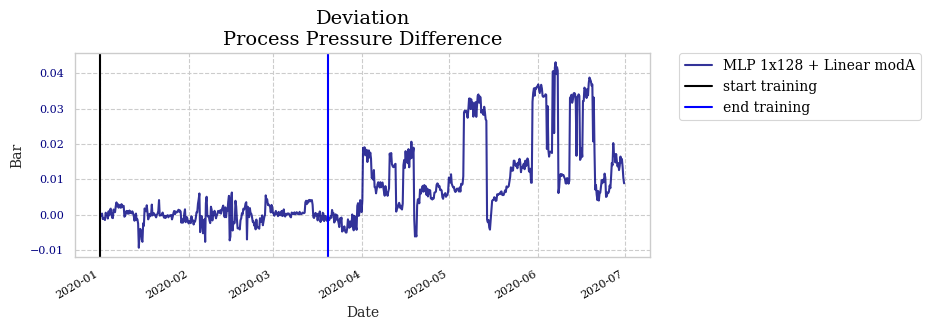

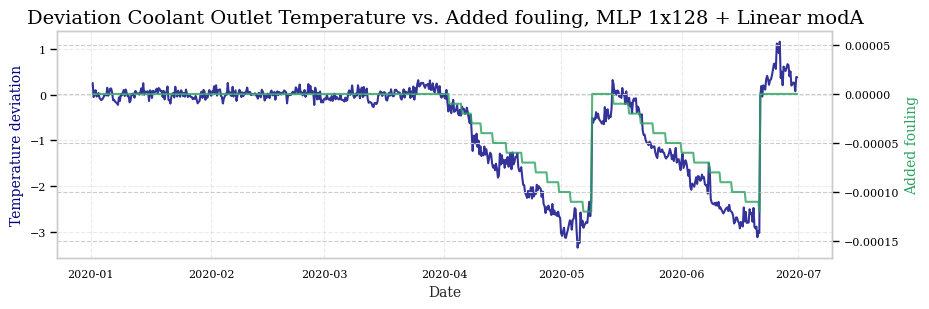

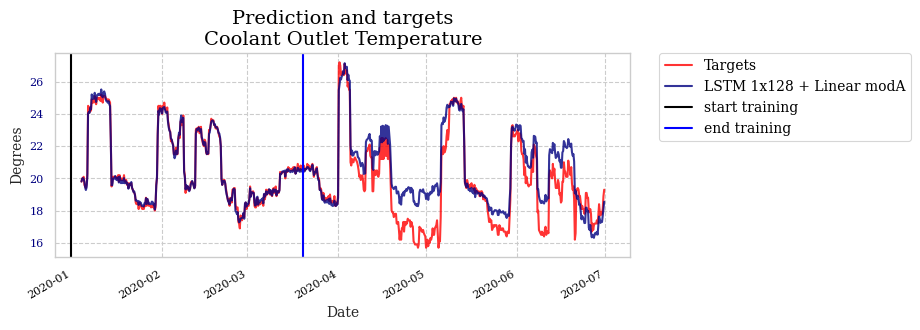

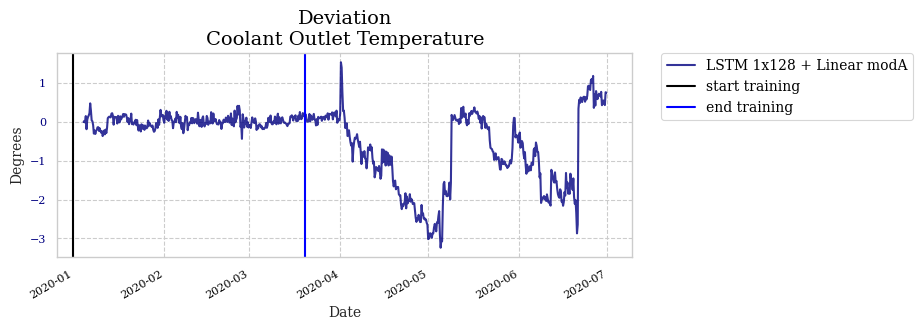

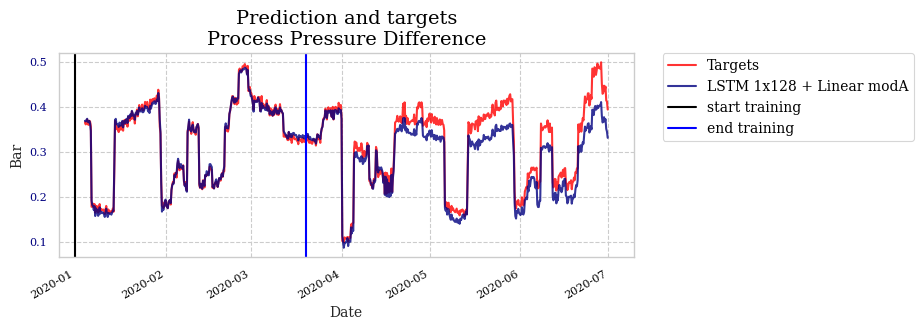

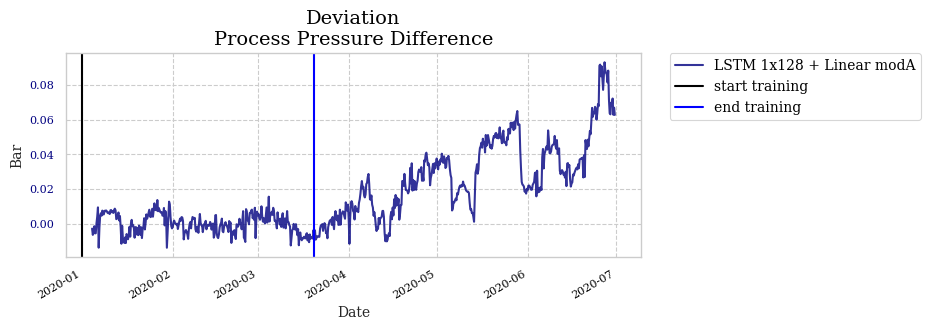

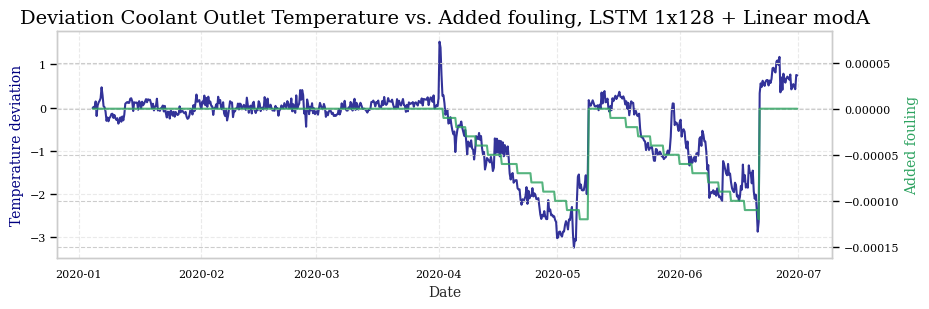

In [7]:
import src.utils.utilities as utils
import src.utils.plots as plots
import matplotlib.pyplot as plt

df_fouling = utils.readDataFile('../master-thesis-db/datasets/D/foulingC.csv')
df_fouling = utils.getDataWithTimeIndex(df_fouling)

def foulingPlot(deviationsList, name):
    y1 = deviationsList[0][0][2]
    y2 = (-1)* df_fouling['Fouling'].values[mlModule._maxEnrolWindow:]
    x = mlModule._indexColumn

    plots.duoPlot(y1, y2, x, plt, y2lim=(-0.000125+(min(y1)+2.5)*0.00005, 0.0+max(y1)*0.000055), textArgs=[
        'Deviation Coolant Outlet Temperature vs. Added fouling, ' + name,
        'Date',
        'Temperature deviation',
        'Added fouling',
    ])

for model in modelList:
    mlModule.initModels([model])
    modelNames, metrics_train, metrics_test, columnsList, deviationsList = mlModule.predictWithModels(
        plot=True,
        interpol=False,
        score=False,
    )
    foulingPlot(deviationsList, model.name)

# Conclusions

Asd